# Image classification using Convolutional Neural Network 
### Name: Vuong, Annie, Shaina

In this lab, we will explore the fundamentals of image classification using Convolutional Neural Networks (CNNs). The goal is to design and implement a custom CNN architecture for classifying images into six categories: building, glacier, street, forest, mountain, and sea. We will train this custom model from scratch and evaluate its performance. Additionally, we will compare the accuracy and efficiency of our model against the ResNet50 architecture, a pre-trained state-of-the-art deep learning model known for its robustness and high accuracy. By contrasting these two approaches, we aim to understand the advantages of transfer learning with pre-trained models and the challenges of building models from scratch. This exercise highlights the trade-offs between custom model design and leveraging pre-trained architectures in image classification tasks.

The dataset used in this lab is provided by Intel and is known as the Intel Image Classification dataset. It contains a diverse set of images categorized into six classes: buildings, glaciers, streets, forests, mountains, and seas. The dataset is organized into training, validation, and testing subsets, making it ideal for developing and evaluating image classification models. Each image is labeled according to its category, and the dataset provides a variety of scenes with varying lighting, angles, and compositions. This variability ensures a realistic challenge for the classification task, allowing us to test the robustness of both custom-built and pre-trained models like ResNet50.

In [ ]:
%matplotlib inline
import os
import pandas as pd
import cv2, glob
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob 
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

tf.__version__ == '2.13.0', keras.__version__ == '2.13.1'

(True, True)

### 1. Loading and showing data 

In [ ]:
# load data from the directory
data2_validation_set = tf.keras.utils.image_dataset_from_directory(
  'seg_train',
  seed=123,
  image_size=(100, 100),
  shuffle=True,
  subset='validation',
  validation_split=0.3,
  batch_size=32,
  labels='inferred',
  class_names=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

data2_training_set = tf.keras.utils.image_dataset_from_directory(
  'seg_train',
  seed=17,
  image_size=(100, 100),
  validation_split=0.3,
  subset='training',
  batch_size=32,
  labels='inferred',
  class_names=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])


data2_train_file_paths = data2_training_set.file_paths
data2_validation_file_paths = data2_validation_set.file_paths



Found 14034 files belonging to 6 classes.
Using 4210 files for validation.
Found 14034 files belonging to 6 classes.
Using 9824 files for training.


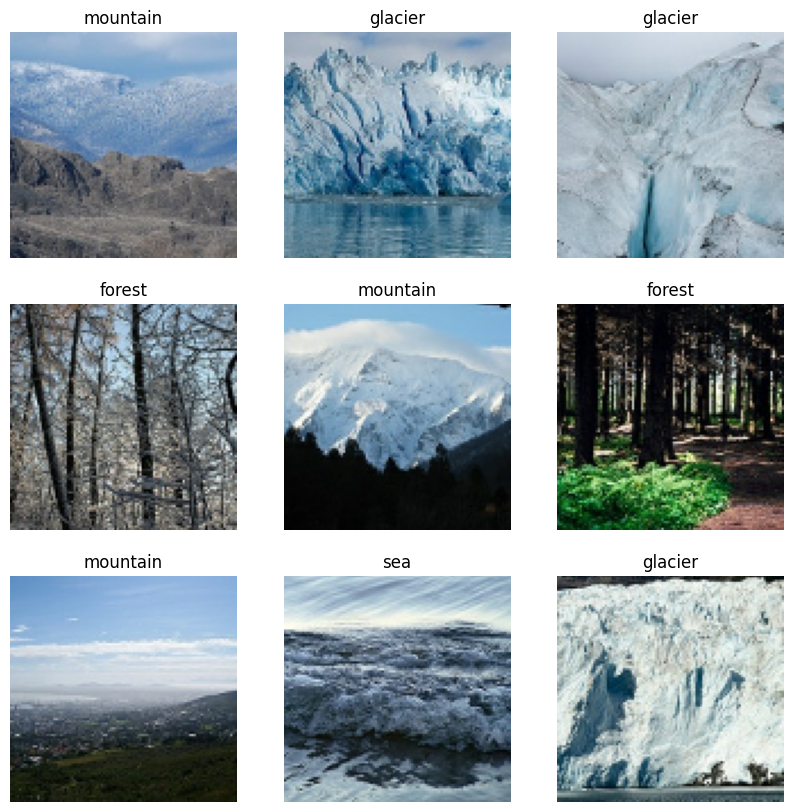

In [ ]:
def show_random_images(dataset):
    """
    Display 9 random images from a TensorFlow dataset
    
    Args:
        dataset: TensorFlow dataset containing images and labels
        n: Number of images to display (default=9)
    """
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):
        # plot images
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(dataset.class_names[labels[i]])
            plt.axis('off')
show_random_images(data2_training_set)

### Buidling and compiling our custom CNN model

We generate our custom model with 3 convolutional, max pooling, and dropout layers. The architecture we used is inspired by several articles we read about Buidling an effective CNN architecture (cited in the paper) and the model suggested by TensorFlow API documentation. 

In [ ]:
from tensorflow.keras.optimizers import Adam
model_data2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 
    tf.keras.layers.Dense(6, activation='softmax')])

# Compile the model
model_data2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model_data2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_62 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_63 (Dropout)        (None, 23, 23, 32)      

In [110]:
history_data2 = model_data2.fit(data2_training_set,
      epochs=10,
      verbose=1,
      validation_data = data2_validation_set)

Epoch 1/10
1965/1965 [==============================] - 36s 18ms/step - loss: 5.0797 - accuracy: 0.3996 - val_loss: 1.2307 - val_accuracy: 0.5176
Epoch 2/10
1965/1965 [==============================] - 34s 17ms/step - loss: 1.1090 - accuracy: 0.5713 - val_loss: 1.0288 - val_accuracy: 0.6359
Epoch 3/10
1965/1965 [==============================] - 38s 19ms/step - loss: 0.9286 - accuracy: 0.6485 - val_loss: 1.0467 - val_accuracy: 0.5936
Epoch 4/10
1965/1965 [==============================] - 36s 18ms/step - loss: 0.8123 - accuracy: 0.6905 - val_loss: 0.9336 - val_accuracy: 0.6442
Epoch 5/10
1965/1965 [==============================] - 40s 20ms/step - loss: 0.7257 - accuracy: 0.7283 - val_loss: 0.9730 - val_accuracy: 0.6295
Epoch 6/10
1965/1965 [==============================] - 41s 21ms/step - loss: 0.6593 - accuracy: 0.7515 - val_loss: 0.8167 - val_accuracy: 0.6960
Epoch 7/10
1965/1965 [==============================] - 37s 19ms/step - loss: 0.6089 - accuracy: 0.7722 - val_loss: 0.7755 -

### Fine-tuning and compiling ResNet50 

Since our model does not return a good result of accuracy score, we import a pre-trained model from TensorFlow ResNet50 to classifiy our data

In [130]:
from keras.models import Sequential
dnn_model = Sequential()
imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(100,100,3),
pooling='avg',
weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

Before using the model, we fine-tune this pre-trained model by adding more layers. Since our data has around 6 categories, we adapt the Dense layer to suits the data better. 

In [131]:
dnn_model.add(imported_model)
dnn_model.add(tf.keras.layers.Flatten())
dnn_model.add(tf.keras.layers.Dense(512, activation='relu'))
dnn_model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [132]:
dnn_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_29 (Flatten)        (None, 2048)              0         
                                                                 
 dense_65 (Dense)            (None, 512)               1049088   
                                                                 
 dense_66 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 24639878 (93.99 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [133]:
# compile the model
dnn_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [134]:
history_resnet = dnn_model.fit(data2_training_set, validation_data=data2_validation_set,
                        epochs=4)

Epoch 1/4
307/307 [==============================] - 123s 396ms/step - loss: 0.4536 - accuracy: 0.8421 - val_loss: 0.2998 - val_accuracy: 0.8905
Epoch 2/4
307/307 [==============================] - 118s 384ms/step - loss: 0.2599 - accuracy: 0.9021 - val_loss: 0.2496 - val_accuracy: 0.9128
Epoch 3/4
307/307 [==============================] - 120s 392ms/step - loss: 0.2065 - accuracy: 0.9237 - val_loss: 0.2393 - val_accuracy: 0.9166
Epoch 4/4
307/307 [==============================] - 126s 411ms/step - loss: 0.1562 - accuracy: 0.9427 - val_loss: 0.2079 - val_accuracy: 0.9323


ResNet50 has the accuracy score improve after only 4 epochs and reached a good accuracy score of around 95%.

### Predicting and evaluating the models

In [ ]:
def calculate_metrics(model, dataset):
    """
    Calculate and display precision, recall, and accuracy scores.
    
    Args:
        model: resnet50 or our custom model
        dataset: validation datset
    """
    # collect predictions and true labels
    y_true = []
    y_pred = []
    
    # Make predictions
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        pred_labels = np.argmax(predictions, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(pred_labels)
    
    # convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # calculate metrics
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # create a dataframe for better visualization
    metrics_df = pd.DataFrame({
        'Class': dataset.class_names,
        'Precision': precision.round(3),
        'Recall': recall.round(3)
    })
    
    # Calculate macro averages
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Print results
    print("\nMetrics per class:")
    print(metrics_df)
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Macro-Precision: {macro_precision:.3f}")
    print(f"Macro-Recall: {macro_recall:.3f}")

In [128]:
calculate_metrics(dnn_model, data2_validation_set)


Metrics per class:
       Class  Precision  Recall
0  buildings      0.955   0.938
1     forest      0.983   0.991
2    glacier      0.849   0.931
3   mountain      0.898   0.861
4        sea      0.973   0.904
5     street      0.943   0.962

Overall Metrics:
Accuracy: 0.930
Macro-Precision: 0.933
Macro-Recall: 0.931


In [129]:
calculate_metrics(model_data2, data2_validation_set)


Metrics per class:
       Class  Precision  Recall
0  buildings      0.922   0.747
1     forest      0.781   0.983
2    glacier      0.868   0.774
3   mountain      0.775   0.807
4        sea      0.748   0.873
5     street      0.906   0.750

Overall Metrics:
Accuracy: 0.822
Macro-Precision: 0.833
Macro-Recall: 0.822


The custom CNN model achieved an accuracy of 82.2%, with strong precision for the building class, demonstrating its ability to capture key features with a simple architecture. In comparison, the ResNet50 model, a more complex pre-trained network, reached an accuracy of 93%. While the custom model's performance was lower, it offers a faster training time and is more computationally efficient, making it a viable option for tasks requiring quicker model deployment, especially when working with large-scale datasets.